<a href="https://colab.research.google.com/github/ericyoc/qr_code_demo_poc/blob/main/qr_code_demonstration_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install qrcode pillow
#!apt-get install libzbar0
#!pip install pyzbar
#!pip install --upgrade pyzbar

In [2]:
import qrcode
from PIL import Image, ImageDraw, ImageFilter
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import os
import random

In [3]:
def generate_qr_code(data):
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)
    qr_image = qr.make_image(fill_color="black", back_color="white").convert('RGB')
    return qr_image

In [4]:
def modify_qr_code(qr_image, logo_path=None, color_scheme=None, pattern=None, gradient=None):
    if logo_path:
        logo = Image.open(logo_path)
        logo_size = int(qr_image.size[0] / 4)  # Adjust the size of the logo
        logo = logo.resize((logo_size, logo_size))

        logo_pos = ((qr_image.size[0] - logo.size[0]) // 2,
                    (qr_image.size[1] - logo.size[1]) // 2)
        qr_image.paste(logo, logo_pos)

    if color_scheme:
        fill_color, back_color = color_scheme
        qr_image = qr_image.convert('RGB')
        r, g, b = qr_image.split()
        r = r.point(lambda x: fill_color[0] if x == 0 else back_color[0])
        g = g.point(lambda x: fill_color[1] if x == 0 else back_color[1])
        b = b.point(lambda x: fill_color[2] if x == 0 else back_color[2])
        qr_image = Image.merge('RGB', (r, g, b))

    if pattern:
        pattern_image = Image.new('RGBA', qr_image.size, color=0)
        draw = ImageDraw.Draw(pattern_image)
        for _ in range(100):
            x1 = random.randint(0, qr_image.size[0])
            y1 = random.randint(0, qr_image.size[1])
            x2 = random.randint(0, qr_image.size[0])
            y2 = random.randint(0, qr_image.size[1])
            draw.line((x1, y1, x2, y2), fill=(255, 255, 255, 128), width=2)
        qr_image = Image.alpha_composite(qr_image.convert('RGBA'), pattern_image)

    if gradient:
        # Create a gradient mask with the same size as the QR code
        gradient_mask = Image.new('L', qr_image.size, color=0)
        draw = ImageDraw.Draw(gradient_mask)
        for i in range(qr_image.size[1]):
            draw.line((0, i, qr_image.size[0], i), fill=int(255 * (1 - i / qr_image.size[1])))

        # Apply the gradient to the background of the QR code
        gradient_image = Image.new('RGB', qr_image.size, color=0)
        gradient_colors = gradient(gradient_image.size)  # Call the gradient function to get the colors
        gradient_image.putdata(gradient_colors)
        gradient_image.paste(qr_image, mask=qr_image.convert('L'))
        qr_image = gradient_image

    return qr_image

In [5]:
def save_qr_code(qr_image):
    filename = "qr_code.jpg"
    qr_image = qr_image.convert("RGB")  # Convert the image to RGB mode
    qr_image.save(filename, "JPEG")
    print(f"QR code saved as {filename}")

In [6]:
def read_qr_code():
    filename = "qr_code.jpg"
    decoded_objects = decode(Image.open(filename))
    for obj in decoded_objects:
        print("Type:", obj.type)
        print("Data:", obj.data.decode("utf-8"))
    return filename

In [7]:
def display_qr_code(filename):
    image = plt.imread(filename)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [8]:
def random_gradient(size):
    r1, g1, b1 = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    r2, g2, b2 = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)
    return [(int(r1 + (r2 - r1) * i / size[1]),
             int(g1 + (g2 - g1) * i / size[1]),
             int(b1 + (b2 - b1) * i / size[1])) for i in range(size[1])]

In [9]:
def validate_input(data, max_length):
    # Remove any non-printable characters and limit the length
    data = ''.join(char for char in data if char.isprintable())[:max_length]
    return data

In [10]:
def get_input(prompt, max_length):
    while True:
        data = input(prompt)
        if data.lower() == 'cancel':
            return None
        data = validate_input(data, max_length)
        if data:
            return data
        else:
            print("Invalid input. Please try again.")

In [11]:
def main():
    while True:
        print("1. Generate QR Code")
        print("2. Generate QR Code with Custom Image")
        print("3. Change QR Code Color Scheme")
        print("4. Apply Random Pattern to QR Code")
        print("5. Apply Random Gradient to QR Code")
        print("6. Read QR Code")
        print("7. Quit")
        choice = input("Enter your choice (1-7): ")[:1]

        if choice == "1":
            data = get_input("Enter the data to encode (up to 40 characters) or 'cancel' to go back: ", max_length=40)
            if data is None:
                continue
            qr_image = generate_qr_code(data)
            save_qr_code(qr_image)
            display_qr_code("qr_code.jpg")
        elif choice == "2":
            data = get_input("Enter the data to encode (up to 40 characters): ", max_length=40)
            if data is None:
                continue
            logo_path = input("Enter the path to the custom image file (or 'cancel' to go back): ")
            if logo_path.lower() == 'cancel':
                continue
            qr_image = generate_qr_code(data)
            qr_image = modify_qr_code(qr_image, logo_path=logo_path)
            save_qr_code(qr_image)
            display_qr_code("qr_code.jpg")
        elif choice == "3":
            if not os.path.exists("qr_code.jpg"):
                print("No QR code found. Please generate a QR code first.")
                data = get_input("Enter the data to encode (up to 40 characters) or 'cancel' to go back: ", max_length=40)
                if data is None:
                    continue
                qr_image = generate_qr_code(data)
                save_qr_code(qr_image)
            else:
                print("Choose a color scheme:")
                print("r - Red and White")
                print("b - Blue and White")
                print("y - Yellow and Black")
                print("c - Cancel")
                color_choice = input("Enter your choice (r/b/y/c): ")[:1].lower()
                if color_choice == 'c':
                    continue
                elif color_choice == 'r':
                    color_scheme = ((255, 0, 0), (255, 255, 255))
                elif color_choice == 'b':
                    color_scheme = ((0, 0, 255), (255, 255, 255))
                elif color_choice == 'y':
                    color_scheme = ((255, 255, 0), (0, 0, 0))
                else:
                    print("Invalid choice. No color scheme applied.")
                    continue
                qr_image = Image.open("qr_code.jpg")
                qr_image = modify_qr_code(qr_image, color_scheme=color_scheme)
                save_qr_code(qr_image)
            display_qr_code("qr_code.jpg")
        elif choice == "4":
            if not os.path.exists("qr_code.jpg"):
                print("No QR code found. Please generate a QR code first.")
                data = get_input("Enter the data to encode (up to 40 characters) or 'cancel' to go back: ", max_length=40)
                if data is None:
                    continue
                qr_image = generate_qr_code(data)
                save_qr_code(qr_image)
            else:
                qr_image = Image.open("qr_code.jpg")
                qr_image = modify_qr_code(qr_image, pattern=True)
                save_qr_code(qr_image)
            display_qr_code("qr_code.jpg")
        elif choice == "5":
            if not os.path.exists("qr_code.jpg"):
                print("No QR code found. Please generate a QR code first.")
                data = get_input("Enter the data to encode (up to 40 characters) or 'cancel' to go back: ", max_length=40)
                if data is None:
                    continue
                qr_image = generate_qr_code(data)
                save_qr_code(qr_image)
            else:
                qr_image = Image.open("qr_code.jpg")
                qr_image = modify_qr_code(qr_image, gradient=random_gradient)
                save_qr_code(qr_image)
            display_qr_code("qr_code.jpg")
        elif choice == "6":
            try:
                decoded_filename = read_qr_code()
                display_qr_code(decoded_filename)
            except FileNotFoundError:
                print("QR code image file not found.")
        elif choice == "7":
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please try again.")

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 1
Enter the data to encode (up to 40 characters) or 'cancel' to go back: This is very cool!
QR code saved as qr_code.jpg


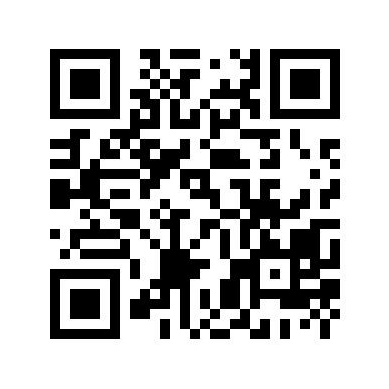

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 3
Choose a color scheme:
r - Red and White
b - Blue and White
y - Yellow and Black
c - Cancel
Enter your choice (r/b/y/c): y
QR code saved as qr_code.jpg


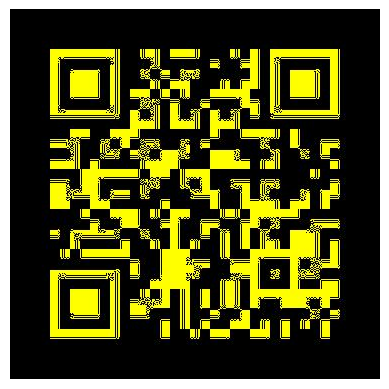

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 4
QR code saved as qr_code.jpg


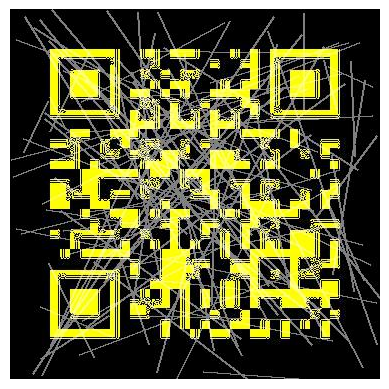

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 5
QR code saved as qr_code.jpg


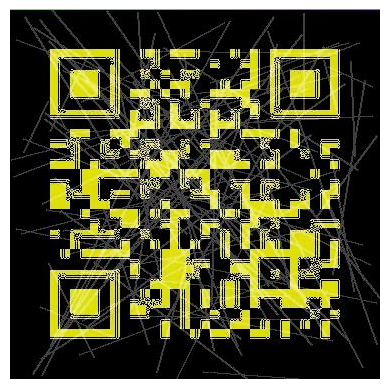

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 6


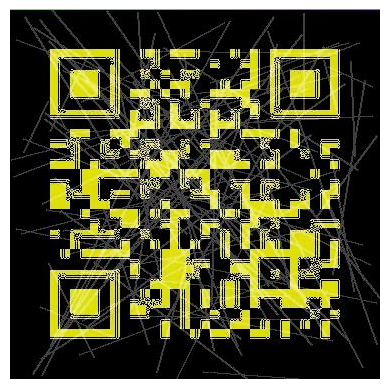

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 2
Enter the data to encode (up to 40 characters): This is yet another very cool smiley day!
Enter the path to the custom image file (or 'cancel' to go back): happy_face_image.jpg
QR code saved as qr_code.jpg


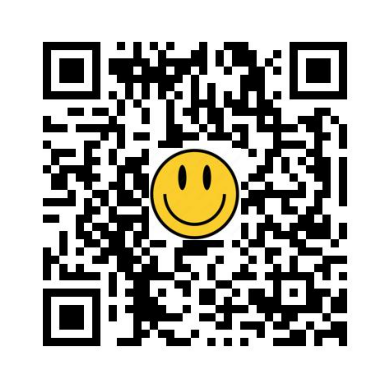

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 3
Choose a color scheme:
r - Red and White
b - Blue and White
y - Yellow and Black
c - Cancel
Enter your choice (r/b/y/c): r
QR code saved as qr_code.jpg


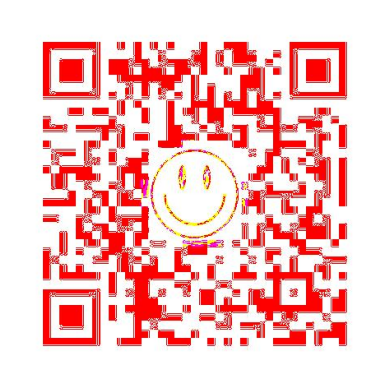

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 5
QR code saved as qr_code.jpg


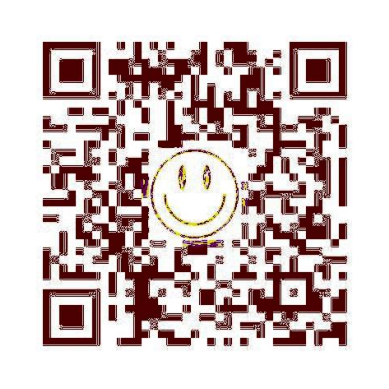

1. Generate QR Code
2. Generate QR Code with Custom Image
3. Change QR Code Color Scheme
4. Apply Random Pattern to QR Code
5. Apply Random Gradient to QR Code
6. Read QR Code
7. Quit
Enter your choice (1-7): 7
Exiting...


In [12]:
if __name__ == "__main__":
    main()